# Assignment 3 - Reinforcement Learning

## GridWorlds

This assignment involves finding optimal policies for two grid worlds (CliffWalking and WindyGridWorld) using SARSA and Q learning. Details about WindyGridWorld (Example 6.5) and CliffWalking (Example 6.6) can be found in the following link.
    
    http://incompleteideas.net/book/RLbook2020.pdf


You need gym (version 0.18) and numpy (version 1.20.1) for this assignment. The environment for both problems are provided. 

For Windy Grid World environemnt you also need the file 'WindyGridWorld.py'. 

### Task 1: Learning [5 Marks]

You only need to write the codes for SARSA and Q-learning algorithms. Then do the learning in both 'CliffWalking' and 'Windy Grid World' environments. 

### Task 2: Analysis [5 Marks]   

1. Calculate the average return across the episodes. It gives you a measure of the performance of the algorithm while learning.  

2. Calculate the return after convergence. It gives you a measure of the performance after the learning is completed. 

3. What do you observe from these results?

Install the necessary packages

In [5]:
!pip install gym==0.18
!pip install numpy==1.20.1
!pip install tqdm 


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Task 1: Learning
## Task 1a: Learning in CliffWalking Environment

### Environment for CliffWalking

The board is a 4x12 matrix, with (using NumPy matrix indexing):
    [3, 0] as the start at bottom-left
    [3, 11] as the goal at bottom-right
    [3, 1..10] as the cliff at bottom-center

Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
and a reset to the start. If an action would take you off the grid, you remain in the previous state.
An episode terminates when the agent reaches the goal.


In [119]:

import gym
import numpy as np
from tqdm import tqdm 

env = gym.make('CliffWalking-v0') # Create the environment #render_mode="human"  human, ansi, 
env.reset() # reset environment to a new, random state
env.render() # Renders the environment for visualization

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



Here _x_ is the location of the agent, *o* are possible places to go to, *C* is the cliff, and *T* is the target.

In [120]:
num_actions = env.action_space.n 
num_states = env.observation_space.n 

print("Number of actions: ", num_actions)
print("Number of states: ", num_states)

Number of actions:  4
Number of states:  48


In [121]:
action = 0 # Move up
a = env.step(action) # This is the function we use to interact with the environment
env.render() # Renders the environment for visualization

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [122]:
# 0 -> UP, 1 -> RIGHT, 2 -> DOWN, 3 -> LEFT
env.reset()
import time
for action in [0, 1, 2, 3]:
    print("Action: ", action)
    time.sleep(1)
    next_state, reward, is_done, info = env.step(action)     # next_state, reward, is_done, info
    print("Next state: ", next_state)
    print("Reward: ", reward)
    print("Done: ",is_done)
    env.render()
env.reset()

Action:  0
Next state:  24
Reward:  -1
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action:  1
Next state:  25
Reward:  -1
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action:  2
Next state:  36
Reward:  -100
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action:  3
Next state:  36
Reward:  -1
Done:  False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



36

As you can see above, each non-terminal action has a reward of -1. 0 -> UP, 1 -> RIGHT, 2 -> DOWN, 3 -> LEFT. The moment the agent falls off the cliff the reward becomes -100 and the agent resets to the start.

In [123]:
# Initialize values 
num_episodes = 500

# initialize learning rate alpha as 0.5 and epsilon as 0.1
lr = 0.5
epsilon = 0.1

# As in RLbook2020, we treat this problem as an undiscounted episodic task
# i.e. gamma = 1
gamma = 1

In [124]:
# Initialize Q function - a simplified version is used here 
# in reality the number of states may be unknown and all states may not be reachable 

# hint: use num_states as the key to a dictionary of lists

# initialize Q(s,a) = 0 for all s,a.
# The final structure of Q looks like:
# Q = {0: [0, 0, 0, 0], 1: [0, 0, 0, 0], 2: [0, 0, 0, 0], 3: [0, 0, 0, 0], 4: [0, 0, 0, 0], 5: [0, 0, 0, 0], 6: [0, 0, 0, 0], 
#  7: [0, 0, 0, 0], 8: [0, 0, 0, 0], 9: [0, 0, 0, 0], 10: [0, 0, 0, 0], 11: [0, 0, 0, 0], 12: [0, 0, 0, 0], 13: [0, 0, 0, 0], 
#  14: [0, 0, 0, 0], 15: [0, 0, 0, 0], 16: [0, 0, 0, 0], 17: [0, 0, 0, 0], 18: [0, 0, 0, 0], 19: [0, 0, 0, 0], 20: [0, 0, 0, 0],
#  21: [0, 0, 0, 0], 22: [0, 0, 0, 0], 23: [0, 0, 0, 0], 24: [0, 0, 0, 0], 25: [0, 0, 0, 0], 26: [0, 0, 0, 0], 27: [0, 0, 0, 0],
#  28: [0, 0, 0, 0], 29: [0, 0, 0, 0], 30: [0, 0, 0, 0], 31: [0, 0, 0, 0], 32: [0, 0, 0, 0], 33: [0, 0, 0, 0], 34: [0, 0, 0, 0],
#  35: [0, 0, 0, 0], 36: [0, 0, 0, 0], 37: [0, 0, 0, 0], 38: [0, 0, 0, 0], 39: [0, 0, 0, 0], 40: [0, 0, 0, 0], 41: [0, 0, 0, 0],
#  42: [0, 0, 0, 0], 43: [0, 0, 0, 0], 44: [0, 0, 0, 0], 45: [0, 0, 0, 0], 46: [0, 0, 0, 0], 47: [0, 0, 0, 0]}
Q = {i: [0] * num_actions for i in range(num_states)}

In [125]:
def behavioral_policy(state, Q, num_actions, epsilon):
    # Implement the epsilon-greedy policy
    # Don't forget the epsilon-greedy idea
    
    # prob[best_action] = 1 - epsilon + epsilon/num_actions, prob[non-greedy_action] = epsilon/num_actions
    probs = np.full(num_actions, epsilon / num_actions)
    best_action = np.argmax(Q[state])
    probs[best_action] += 1 - epsilon
    
    action = np.argmax(np.random.multinomial(1, probs, size=1)[0])
    return action


# result = {i: 0 for i in range(4)}
# for i in range(100): 
#     action = behavioral_policy(0, {0: [1,0,2,0]}, 4, 0.8)
#     result[action] += 1
# print(result)


In [126]:
# You can use this to check if your algorithm is correct
for i in range(10):
    print(behavioral_policy(0, Q, num_actions, 0.8))

1
1
2
0
0
1
2
1
0
2


### SARSA Learning 

In [127]:
def sarsa(env, Q, num_actions, num_episodes, epsilon, lr):
    # Given to students
    episode_length = [0] * num_episodes
    total_reward_episode = [0] * num_episodes
    

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        # Implement SARSA
        
        action = behavioral_policy(state, Q, num_actions, epsilon)
        while not is_done:
            # take action in state
            next_state, reward, is_done, _ = env.step(action)
            # get next_action for next_state using behavioral policy
            next_action = behavioral_policy(next_state, Q, num_actions, epsilon)
            # calculate TD error
            target = reward + gamma * Q[next_state][next_action]
            predict = Q[state][action]
            error = target - predict
            # update Q[state][action]
            Q[state][action] = Q[state][action] + lr * error
            # update state as next_state, update action as next_action
            state = next_state
            action = next_action
            
            episode_length[episode] += 1
            total_reward_episode[episode] += reward
    policy = {}
    # Write code here as well
    # Hint: use np.argmax
    
    # calculate final found policy for each state 
    for s in Q:
        policy[s] = np.argmax(Q[s])

    return Q, policy, {"rewards": total_reward_episode, "length": episode_length}

In [128]:
# Run SARSA

# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}

optimal_sarsa_Q, sarsa_optimal_policy, sarsa_info = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)
print("\nGridWorld SARSA Optimal policy: \n", sarsa_optimal_policy)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1403.00it/s]


GridWorld SARSA Optimal policy: 
 {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 1, 18: 1, 19: 0, 20: 0, 21: 0, 22: 1, 23: 2, 24: 0, 25: 0, 26: 3, 27: 0, 28: 0, 29: 1, 30: 0, 31: 0, 32: 0, 33: 3, 34: 1, 35: 2, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}


### Q-Learning

In [129]:
def q_learning(env, Q, num_actions, num_episodes, epsilon, lr):
    # Given to students
    episode_length = [0] * num_episodes
    total_reward_episode = [0] * num_episodes

   
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        is_done = False
        # Implemnt Q-Learning
        
        while not is_done:
            # Choose action from state using behavioral policy 
            action = behavioral_policy(state, Q, num_actions, epsilon)
            # take action in state
            next_state, reward, is_done, _ = env.step(action)
            # calculate TD error
            target = reward + gamma * max(Q[next_state])
            predict = Q[state][action]
            error = target - predict
            # update Q[state][action]
            Q[state][action] = Q[state][action] + lr * error
            # update state as next_state
            state = next_state

            total_reward_episode[episode] += reward
            episode_length[episode] += 1
            
    policy = {}
    # Write the code here
    
    # calculate final found policy for each state 
    for s in Q:
        policy[s] = np.argmax(Q[s])

    return Q, policy, {"rewards": total_reward_episode, "length": episode_length}

In [130]:
# Run Q-Learning 

# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}

optimal_Q, q_optimal_policy, q_info = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)
print("\nGridWorld Q-Learning Optimal policy: \n", q_optimal_policy)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1633.98it/s]


GridWorld Q-Learning Optimal policy: 
 {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 1, 13: 1, 14: 1, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 1, 23: 2, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 2, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}


In [131]:
# run this cell if you do not have the matplotlib library
# !pip install matplotlib
import matplotlib.pyplot as plt

In [132]:
def plot_rate(episode_length, total_reward_episode, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(episode_length)
    ax[0].set_title("Episode Length over time")
    ax[0].set(xlabel="Episode", ylabel="Length")
    ax[1].plot(total_reward_episode)
    ax[1].set_title("Episode reward over time")
    ax[1].set(xlabel="Episode reward over time", ylabel="Reward")
    fig.suptitle(title)

    plt.show()

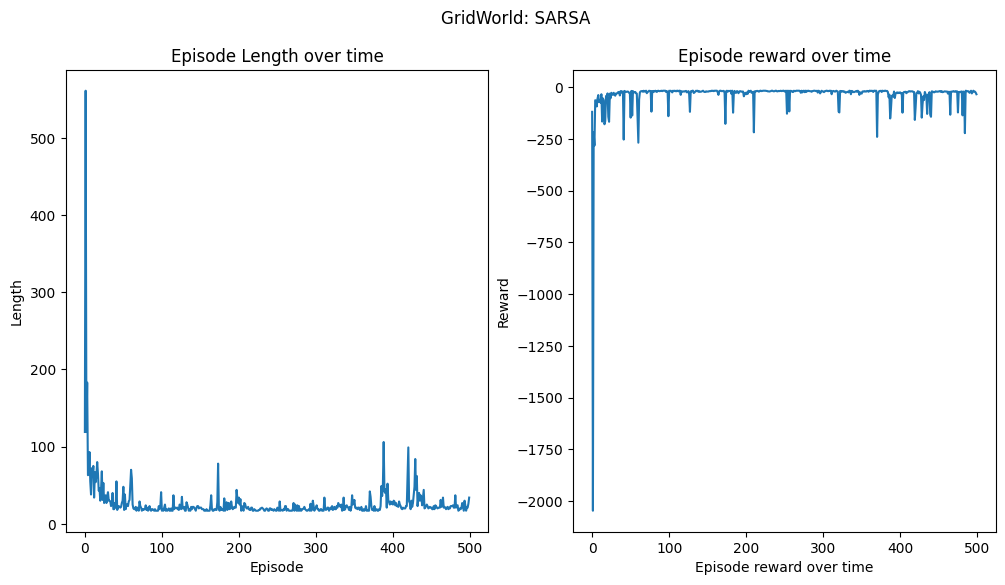

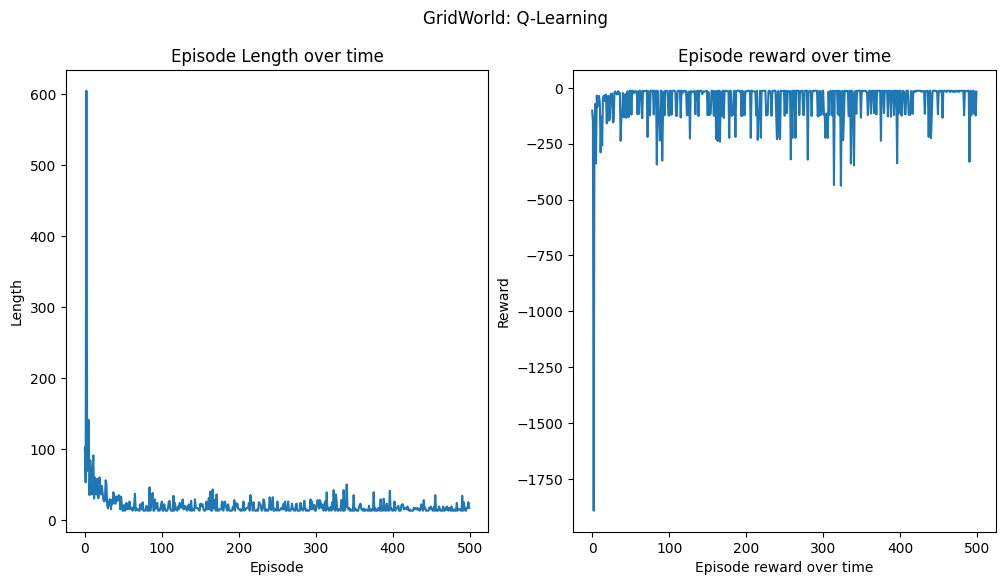

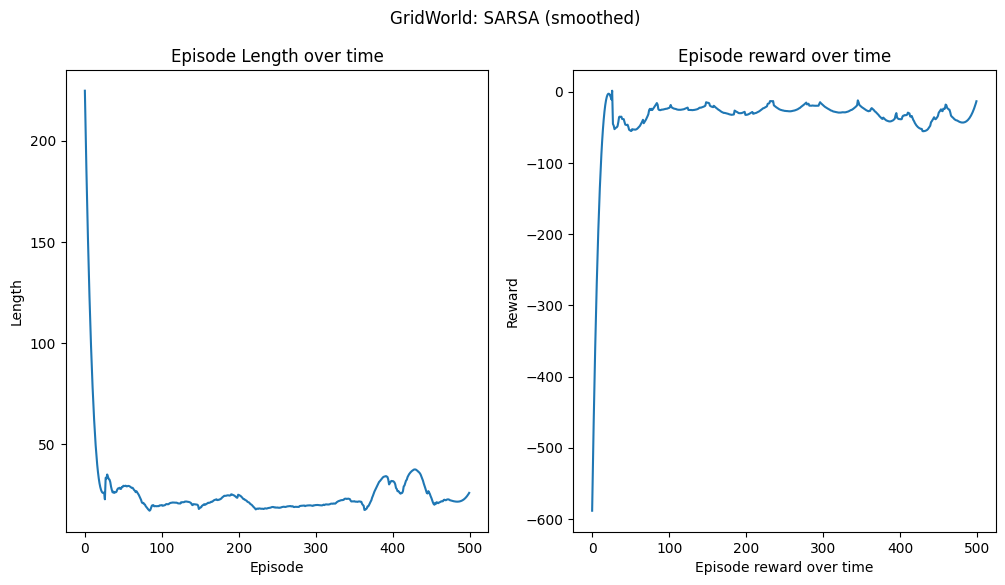

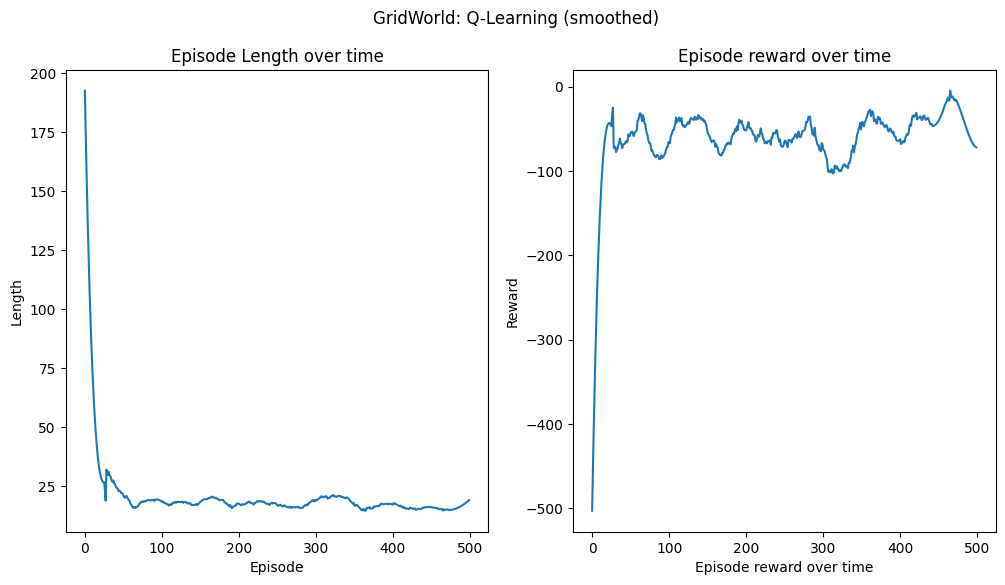

In [133]:
plot_rate(sarsa_info["length"], sarsa_info["rewards"], "GridWorld: SARSA")
plot_rate(q_info["length"], q_info["rewards"], "GridWorld: Q-Learning")

# smooth the curve drawn
from scipy.signal import savgol_filter
plot_rate(savgol_filter(sarsa_info["length"],51,3), savgol_filter(sarsa_info["rewards"],51,3), "GridWorld: SARSA (smoothed)")
plot_rate(savgol_filter(q_info["length"],51,3), savgol_filter(q_info["rewards"],51,3), "GridWorld: Q-Learning (smoothed)")

## Task 1b: Learning in Windy Grid world

WindyGridWorld is similar to GridWorld, but with a few differences. You only need to move to the target state. But this time there is a cross-wind across the center of the grid that will push you upwards. In columns 3, 4, 5, and 8 there are winds of strength 1 while in column 6 and 7 there are winds of strength 2. For more details refer Example 6.5 in

 http://incompleteideas.net/book/RLbook2020.pdf

 You only need to change the environment and reuse the SARSA and Q-learning algorithms. 

In [134]:
#Windy Grid World environment
from WindyGridWorld import WindyGridWorld
env = WindyGridWorld()
env.reset()
env.render()

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [135]:
num_actions = env.action_space.n 
num_states = env.observation_space.n 

print("Number of actions: ", num_actions)
print("Number of states: ", num_states)

Number of actions:  4
Number of states:  70


Play around with different learning rates epsilons, and Q initializations to see what is best.

In [141]:
num_episodes = 1000
lr = 0.7
epsilon = 0.1 

In [142]:
# Initialize Q function - a simplified version is used here 
# in reality the number of states may be unknown and all states may not be reachable 

# hint: use num_states as the key to a dictionary of lists

# initialize Q(s,a) as 0 for all s,a
Q = {i: [0] * num_actions for i in range(num_states)}

In [143]:
# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}

optimal_sarsa_Q, sarsa_optimal_policy, sarsa_info = sarsa(env, Q, num_actions, num_episodes, epsilon, lr)
print("\n WindyGridWorld SARSA Optimal policy: \n", sarsa_optimal_policy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1223.93it/s]


 WindyGridWorld SARSA Optimal policy: 
 {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 1, 11: 2, 12: 1, 13: 1, 14: 1, 15: 1, 16: 2, 17: 2, 18: 0, 19: 2, 20: 1, 21: 2, 22: 0, 23: 1, 24: 1, 25: 2, 26: 2, 27: 3, 28: 1, 29: 2, 30: 1, 31: 2, 32: 0, 33: 1, 34: 1, 35: 1, 36: 2, 37: 0, 38: 1, 39: 2, 40: 1, 41: 2, 42: 2, 43: 0, 44: 1, 45: 1, 46: 0, 47: 2, 48: 3, 49: 3, 50: 1, 51: 2, 52: 0, 53: 1, 54: 3, 55: 0, 56: 0, 57: 2, 58: 3, 59: 3, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 3, 69: 2}


In [144]:
# reset Q(s,a) as all zero before start learning
Q = {i: [0] * num_actions for i in range(num_states)}

optimal_Q, q_optimal_policy, q_info = q_learning(env, Q, num_actions, num_episodes, epsilon, lr)
print("\n WindyGridWorld Q-Learning Optimal policy: \n", q_optimal_policy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2142.48it/s]


 WindyGridWorld Q-Learning Optimal policy: 
 {0: 3, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 3, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 2, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 0, 28: 1, 29: 2, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 0, 38: 1, 39: 2, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 0, 47: 2, 48: 3, 49: 3, 50: 2, 51: 1, 52: 1, 53: 1, 54: 1, 55: 0, 56: 0, 57: 2, 58: 3, 59: 3, 60: 1, 61: 1, 62: 1, 63: 1, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 1}


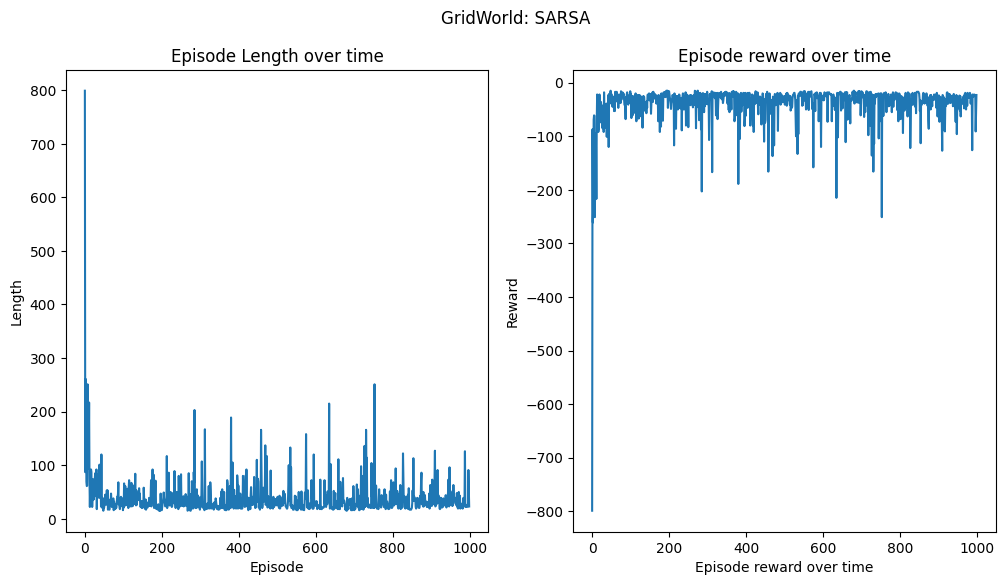

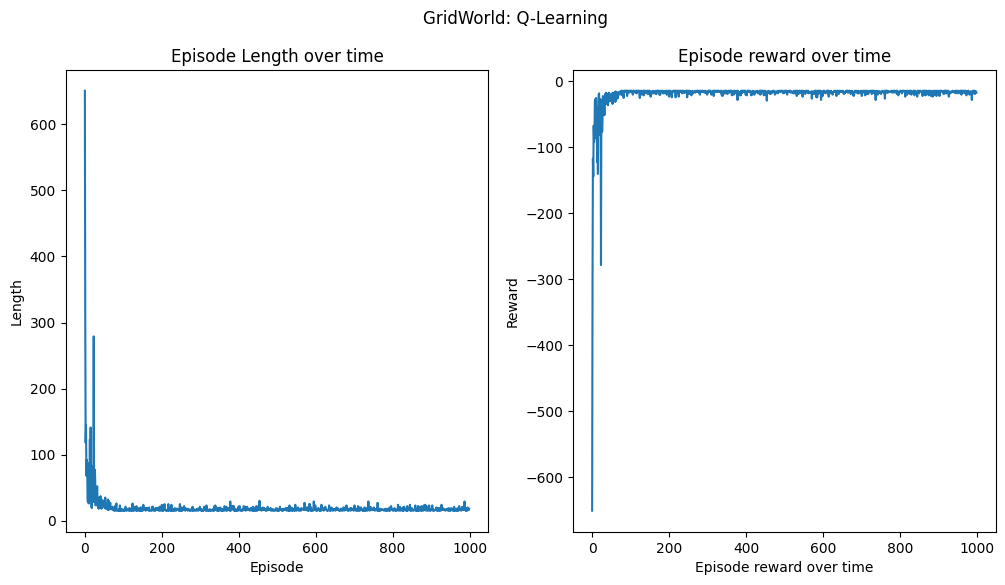

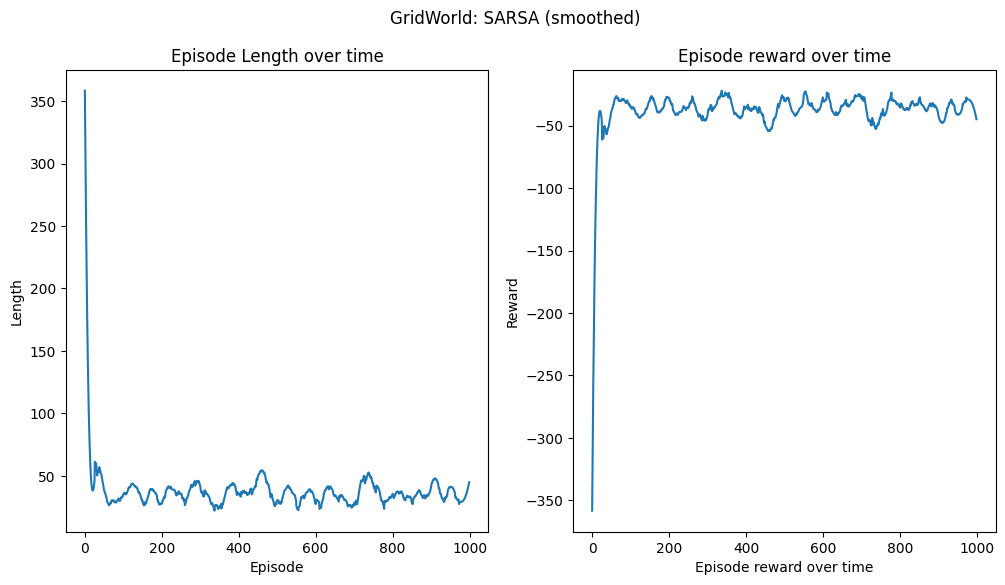

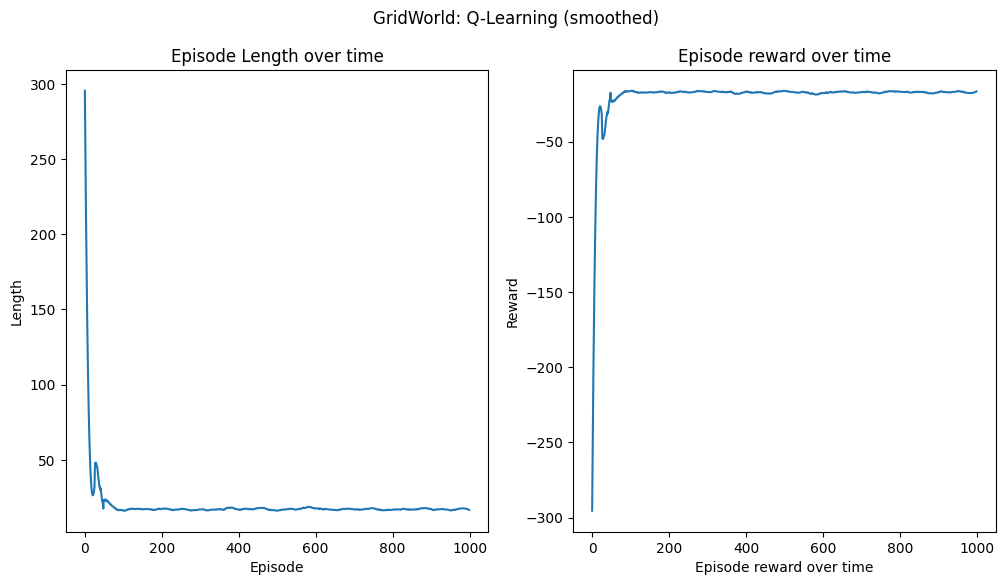

In [145]:
plot_rate(sarsa_info["length"], sarsa_info["rewards"], "GridWorld: SARSA")
plot_rate(q_info["length"], q_info["rewards"], "GridWorld: Q-Learning")

# smooth the curve drawn
from scipy.signal import savgol_filter
plot_rate(savgol_filter(sarsa_info["length"],51,3), savgol_filter(sarsa_info["rewards"],51,3), "GridWorld: SARSA (smoothed)")
plot_rate(savgol_filter(q_info["length"],51,3), savgol_filter(q_info["rewards"],51,3), "GridWorld: Q-Learning (smoothed)")

# Task 2: Analysis (Comparison of Q-learning and SARSA learning algorithms)

1. Comment on the number of episodes required to converge to the optimal policy for both environments. 
       
2. Discuss the differences in the reward graphs.  

3. Calculate the average return across the episodes for each environment. It gives a measure of the performance of the algorithm while learning (i.e., online performance).  

4. Calculate the return after convergence. It gives you a measure of the performance after the learning is completed (i.e., offline performance). 

5. Briefly summarize your results.
 
 It is advisable to rerun the algorithm a few times to get a clearer understanding of the algorithms.